In [1]:
import __init__
import scripts.config as config
import numpy as np
import pandas as pd
import tempfile
import datetime
from sklearn.svm import SVR
import geopandas as gpd
from sklearn.metrics import mean_squared_error as mse
from matplotlib.font_manager import FontProperties
import seaborn as sns
# import matplotlib as mpl
import matplotlib.pyplot as plt
import importlib

In [17]:
%matplotlib inline

XSMALL_SIZE = 6
SMALL_SIZE = 7
MEDIUM_SIZE = 8
BIGGER_SIZE = 11

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=XSMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=XSMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=XSMALL_SIZE)    # legend fontsize
plt.rc('axes', titlesize=8)  # fontsize of the figure title
plt.rcParams['figure.dpi'] = 140

In [3]:
# Import and format observed data
runoff_obs = pd.read_csv(config.velma_data / 'runoff' / 'ellsworth_Q_2004_2007.csv', names=['runoff_obs'])
runoff_obs.index = pd.date_range('01-01-2004', '12-31-2007')
runoff_obs['doy'], runoff_obs['year'] = runoff_obs.index.dayofyear, runoff_obs.index.year
quality = pd.read_csv(str(config.streamflow), usecols=['Date', 'Quality'], parse_dates=True, index_col=0)
quality = quality[(quality.index >= pd.to_datetime('01-01-2004')) & (quality.index <= pd.to_datetime('12-31-2007'))]

precip = pd.read_csv(config.velma_data / 'precip' / 'ellsworth_ppt_2004_2019.csv', names=['precip'])
precip.index = pd.date_range('01-01-2004', '12-31-2019')
precip['doy'], precip['year'] = precip.index.dayofyear, precip.index.year

temp = pd.read_csv(config.velma_data / 'temp' / 'ellsworth_temp_2004_2019.csv', names=['temp'])
temp.index = pd.date_range('01-01-2004', '12-31-2019')
temp['doy'], temp['year'] = temp.index.dayofyear, temp.index.year

# Import VELMA outputs
results_dir = config.data_path.parents[0] / 'results'
baseline04_19 = pd.read_csv(results_dir / 'ellsworth_baseline_04_07/DailyResults.csv')

# Format datetime of results
jday_pad = baseline04_19['Day'].apply(lambda x: str(x).zfill(3))
str_year = baseline04_19['Year'].apply(lambda x: str(x))
baseline04_19['year_jday'] = str_year + jday_pad
baseline04_19.index = pd.to_datetime(baseline04_19['year_jday'], format='%Y%j')

## Plotting

In [4]:
# Group measurements by year
runoff_sim_yearly = pd.pivot_table(baseline04_19, index=['Day'], columns=['Year'],
                                   values=['Runoff_All(mm/day)_Delineated_Average'])
runoff_obs_yearly = pd.pivot_table(runoff_obs, index=['doy'], columns=['year'], values=['runoff_obs'])
precip_yearly = pd.pivot_table(precip, index=['doy'], columns=['year'], values=['precip'])

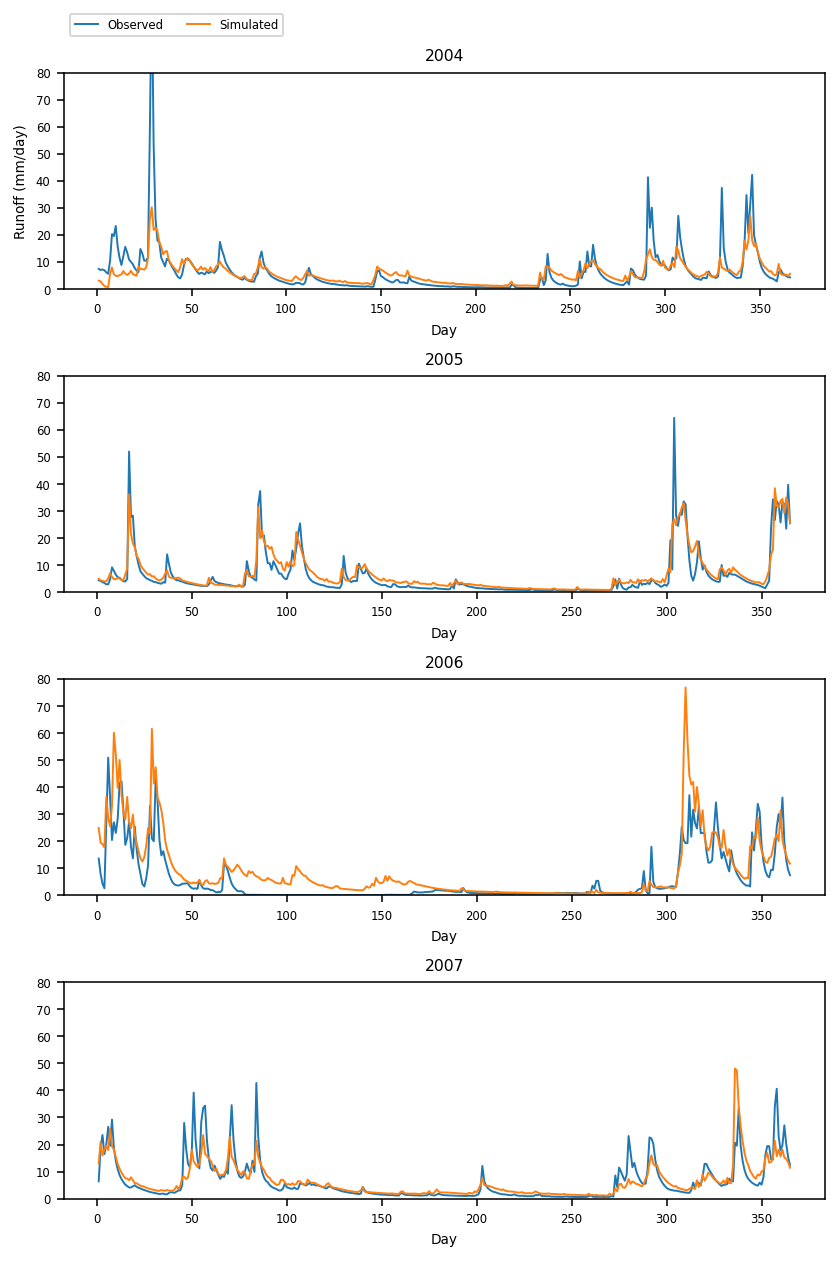

In [18]:
# Observed vs. VELMA simulated runoff
years = runoff_obs_yearly.columns.get_level_values(1)
fig, axes = plt.subplots(ncols=1, nrows=len(years), figsize=(6, 9))
for col, year in enumerate(years):
    runoff_obs_yearly.iloc[:, col].plot(ax=axes[col], label='Observed', linewidth=1)
    runoff_sim_yearly.iloc[:, col].plot(ax=axes[col], label='Simulated', linewidth=1)
    axes[col].set_title(year)
    axes[col].set_ylim([0, 80])
axes[0].legend(loc='upper left', bbox_to_anchor=(0, 1.3), fancybox=True, ncol=2)
axes[0].set_ylabel('Runoff (mm/day)')
plt.tight_layout()

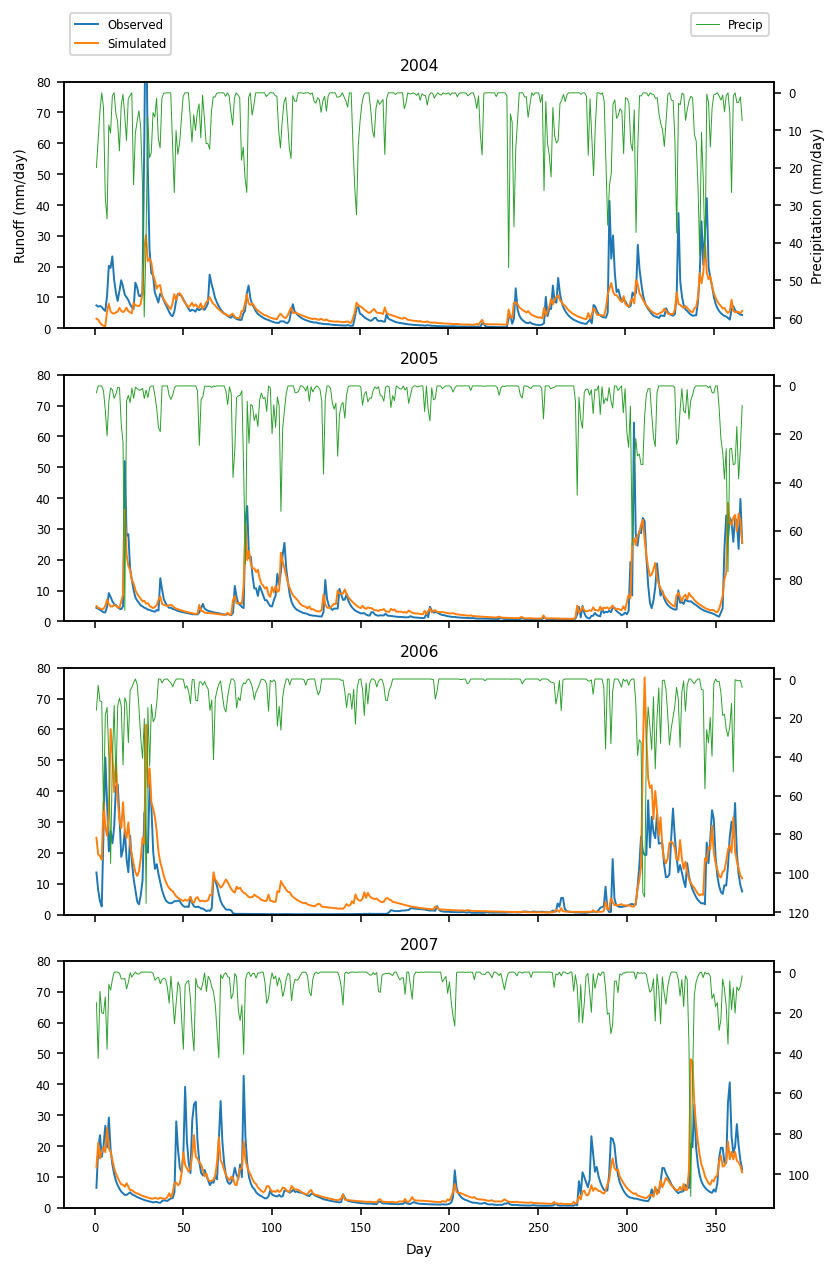

In [25]:
# Runoff and precip
years = runoff_obs_yearly.columns.get_level_values(1)
fig, axes = plt.subplots(ncols=1, nrows=len(years), figsize=(6, 9))

for col, year in enumerate(years):
    ax2 = axes[col].twinx()
    precip_yearly.iloc[:, col].plot(ax=ax2, label='Precip', linewidth=0.5, color='tab:green')
    if col == 0:
        ax2.set_ylabel('Precipitation (mm/day)')
        ax2.legend(loc='upper right', bbox_to_anchor=(1, 1.3), fancybox=True, ncol=1)
    runoff_obs_yearly.iloc[:, col].plot(ax=axes[col], label='Observed', linewidth=1)
    runoff_sim_yearly.iloc[:, col].plot(ax=axes[col], label='Simulated', linewidth=1)
    ax2.invert_yaxis()
    axes[col].set_ylim([0, 80])
    axes[col].set_title(year)
axes[0].legend(loc='upper left', bbox_to_anchor=(0, 1.3))
axes[0].set_ylabel('Runoff (mm/day)')
plt.tight_layout()

Text(0, 0.5, 'Runoff (mm/day)')

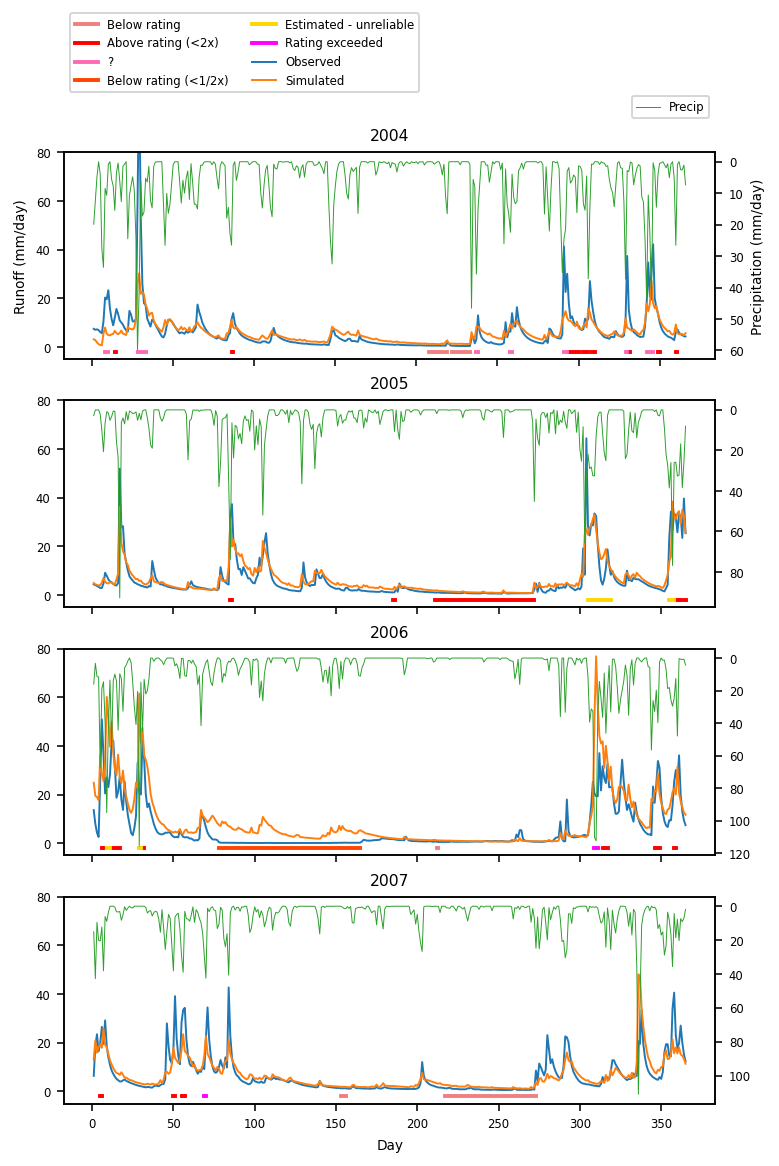

In [21]:
# Add quality scores below plot

quality_edit = quality.copy()

quality_edit['doy'], quality_edit['year'] = quality_edit.index.dayofyear, quality_edit.index.year
quality_edit_yearly = pd.pivot_table(quality_edit, index=['doy'], columns=['year'], values=['Quality'])
quality8 = quality_edit_yearly.replace([2, 3, 8, 10, 50, 77, 160, 161, 179, 254],
                                       [np.nan, np.nan, -2, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan])
quality10 = quality_edit_yearly.replace([2, 3, 8, 10, 50, 77, 160, 161, 179, 254],
                                        [np.nan, np.nan, np.nan, -2, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan])
quality160 = quality_edit_yearly.replace([2, 3, 8, 10, 50, 77, 160, 161, 179, 254],
                                         [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, -2, np.nan, np.nan, np.nan])
quality161 = quality_edit_yearly.replace([2, 3, 8, 10, 50, 77, 160, 161, 179, 254],
                                         [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, -2, np.nan, np.nan])
quality179 = quality_edit_yearly.replace([2, 3, 8, 10, 50, 77, 160, 161, 179, 254],
                                         [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, -2, np.nan])
quality254 = quality_edit_yearly.replace([2, 3, 8, 10, 50, 77, 160, 161, 179, 254],
                                         [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, -2])

years = runoff_obs_yearly.columns.get_level_values(1)
fig, axes = plt.subplots(ncols=1, nrows=len(years), figsize=(6, 9))

for col, year in enumerate(years):
    ax2 = axes[col].twinx()
    precip_yearly.iloc[:, col].plot(ax=ax2, label='Precip', color='tab:green', linewidth=0.5)
    if col == 0:
        ax2.set_ylabel('Precipitation (mm/day)')
        ax2.legend(loc='upper right', bbox_to_anchor=(1, 1.3), fancybox=True, ncol=1)
    quality8.iloc[:, col].plot(ax=axes[col], color='lightcoral', linewidth=2, label='Below rating')
    quality10.iloc[:, col].plot(ax=axes[col], color='red', linewidth=2, label='Above rating (<2x)')
    quality160.iloc[:, col].plot(ax=axes[col], color='hotpink', linewidth=2, label='?')
    quality161.iloc[:, col].plot(ax=axes[col], color='orangered', linewidth=2, label='Below rating (<1/2x)')
    quality179.iloc[:, col].plot(ax=axes[col], color='gold', linewidth=2, label='Estimated - unreliable')
    quality254.iloc[:, col].plot(ax=axes[col], color='fuchsia', linewidth=2, label='Rating exceeded')
    runoff_obs_yearly.iloc[:, col].plot(ax=axes[col], label='Observed', linewidth=1)
    runoff_sim_yearly.iloc[:, col].plot(ax=axes[col], label='Simulated', linewidth=1)
    ax2.invert_yaxis()
    axes[col].set_ylim([-5, 80])
    axes[col].set_title(year)
axes[0].legend(loc='upper left', bbox_to_anchor=(0, 1.7), fancybox=True, ncol=2)
axes[0].set_ylabel('Runoff (mm/day)')

In [32]:
# Average daily flow from 15-minute data and compare to simulated runoff

runoff_obs_15min = pd.read_csv(config.streamflow.parents[0] / 'ells_streamflow_15min_2003_2008.csv',
                               parse_dates={'date_full': ['date', 'time']},
                               usecols=['flow_cfs', 'date', 'time'],
                               dtype={'flow_cfs': np.float32, 'quality': np.int32})

# Convert streamflow from cfs to mm/day
# 2.446576 ft3/sec =  1m3/35.314667ft3 * 1/km2 * 86400sec/1day * 1km2/1000000m2 * 1000mm/1m
ft3_sec = (1 / 35.314667) * 86400 * (1 / 1000000) * 1000
area = 13.7393  # area of upstream Ellsworth watershed, sq. km
runoff_obs_15min['flow_mm_day'] = (runoff_obs_15min['flow_cfs'] / area) * ft3_sec
runoff_obs_15min.drop('flow_cfs', axis=1, inplace=True)

runoff_obs_15min.set_index('date_full', drop=True, inplace=True)
runoff_obs_15min['minute'] = runoff_obs_15min.index.minute
runoff_obs_15min['hour'] = runoff_obs_15min.index.hour
runoff_obs_15min['doy'] = runoff_obs_15min.index.dayofyear
runoff_obs_15min['doy_min_hour'] = (
            runoff_obs_15min['doy'].apply(lambda x: str(x)) + runoff_obs_15min['hour'].apply(lambda x: str(x)) +
            runoff_obs_15min['minute'].apply(lambda x: str(x))).apply(lambda x: int(x))
runoff_obs_15min['year'] = runoff_obs_15min.index.year

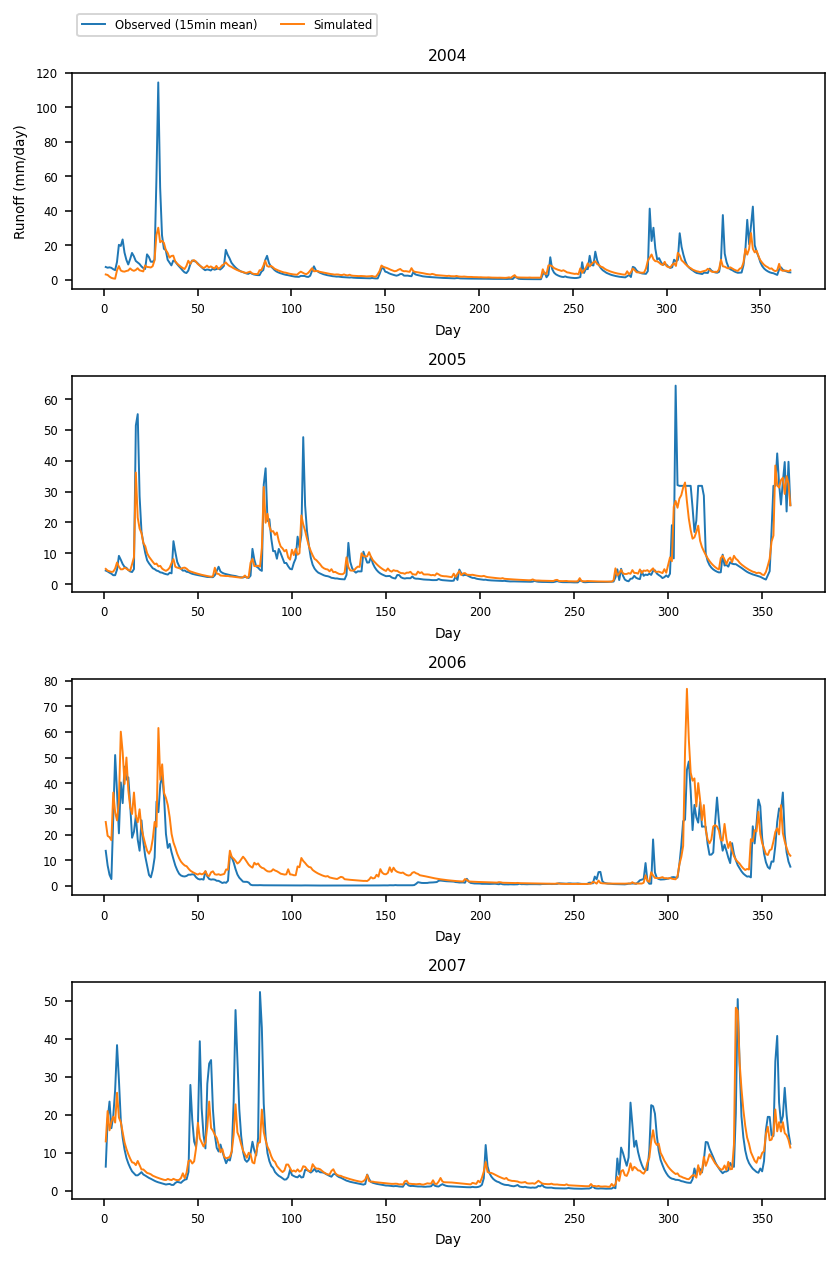

In [33]:
# Plot 15 minute runoff
runoff_obs_15min_yearly = pd.pivot_table(runoff_obs_15min, index=['doy_min_hour'], columns=['year'],
                                         values=['flow_mm_day'])

# Plot average daily runoff
daily_means = runoff_obs_15min.groupby(pd.Grouper(freq='1D')).mean()
runoff_obs_15min_means_yearly = pd.pivot_table(runoff_obs_15min, index=['doy'], columns=['year'],
                                               values=['flow_mm_day'])

# Plot average daily runoff vs. VELMA simulated runoff
runoff_obs_15min_means_yearly.drop(columns=[('flow_mm_day', 2003), ('flow_mm_day', 2008)], inplace=True)
years = runoff_obs_15min_means_yearly.columns.get_level_values(1)
fig, axes = plt.subplots(ncols=1, nrows=len(years), figsize=(6, 9))
for col, year in enumerate(years):
    runoff_obs_15min_means_yearly.iloc[:, col].plot(ax=axes[col], label='Observed (15min mean)', linewidth=1)
    runoff_sim_yearly.iloc[:, col].plot(ax=axes[col], label='Simulated', linewidth=1)
    axes[col].set_title(year)
axes[0].legend(loc='upper left', bbox_to_anchor=(0, 1.3), fancybox=True, ncol=2)
axes[0].set_ylabel('Runoff (mm/day)')
plt.tight_layout()

0.40774519548670735


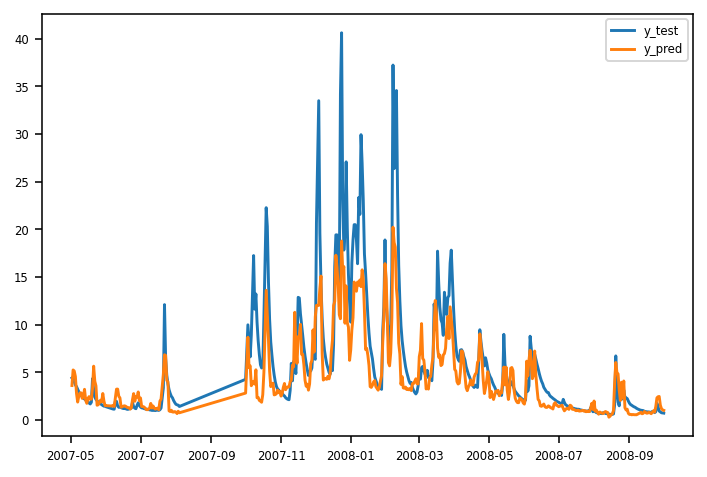

In [34]:
# Use model for runoff imputation to estimate removed values

flow_path = config.streamflow
flow = pd.read_csv(str(flow_path), usecols=['Date', 'Flow_cfs'], parse_dates=True, index_col=0)

# Convert streamflow from cfs to mm/day
# 2.446576 ft3/sec =  1m3/35.314667ft3 * 1/km2 * 86400sec/1day * 1km2/1000000m2 * 1000mm/1m
ft3_sec = (1 / 35.314667) * 86400 * (1 / 1000000) * 1000
area = 13.7393  # area of upstream Ellsworth watershed, sq. km
flow['flow_mm_day'] = (flow['Flow_cfs'] / area) * ft3_sec
flow.drop('Flow_cfs', axis=1, inplace=True)

# Expand date range to include every day of all the years present
begin = '01-01-{}'.format(flow.index.to_frame()['Date'].min().year)
end = '12-31-{}'.format(flow.index.to_frame()['Date'].max().year)
rng = pd.date_range(begin, end)
df = pd.DataFrame(index=rng)
daily_flow = df.merge(flow, left_index=True, right_index=True, how='left')

# Feature engineering
precip = pd.read_csv(str(config.daily_ppt), parse_dates=True, index_col=0)
temp_mean = pd.read_csv(str(config.daily_temp_mean), parse_dates=True, index_col=0)
temp_mean_min = pd.read_csv(str(config.daily_temp_min), parse_dates=True, index_col=0)
temp_mean_max = pd.read_csv(str(config.daily_temp_max), parse_dates=True, index_col=0)
df = pd.concat([precip, temp_mean, temp_mean_min, temp_mean_max], axis=1)

# Convert day of year to signal
day = 24 * 60 * 60
year = 365.2425 * day
timestamp_secs = pd.to_datetime(df.index)
timestamp_secs = timestamp_secs.map(datetime.datetime.timestamp)
df['year_cos'] = np.cos(timestamp_secs * (2 * np.pi / year))
df['year_sin'] = np.sin(timestamp_secs * (2 * np.pi / year))

# Sum of last 2 days precip
df['precip_sum-2t'] = precip.rolling(2).sum()

# Previous days' precip
df['precip_t-1'] = precip['mean_ppt_mm'].shift(1)
df['precip_t-2'] = precip['mean_ppt_mm'].shift(2)
df['precip_t-3'] = precip['mean_ppt_mm'].shift(3)

obs = df.merge(daily_flow['flow_mm_day'], left_index=True, right_index=True, how='right')

# Set aside dates with missing flow measurements
gap_data = obs[obs['flow_mm_day'].isna()]
obs.dropna(inplace=True)

# Remove days with low quality measurements
low_qual = quality[(quality['Quality'].isin([8, 10, 160, 161, 179, 254]))]
shared_index = obs.index.intersection(low_qual.index)
obs_highqual = obs.drop(shared_index)

def plot_test_results(y_test, y_pred):
    results = pd.DataFrame(data=np.column_stack([y_test, y_pred]), index=y_test.index, columns=['y_test', 'y_pred'])
    results = (results * train_std['flow_mm_day']) + train_mean['flow_mm_day']
    plt.plot(results)
    plt.legend(results.columns)


# Split the data 70-20-10
n = obs_highqual.shape[0]
train_df = obs_highqual[0:int(n * 0.7)]
test_df = obs_highqual[int(n * 0.7):]
num_features = obs_highqual.shape[1]

cols = obs_highqual.columns.tolist()
target = cols.index('flow_mm_day')

# Normalize
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

X_train, y_train = train_df.iloc[:, 0:target], train_df.iloc[:, target]
X_test, y_test = test_df.iloc[:, 0:target], test_df.iloc[:, target]

svr = SVR(kernel='rbf', C=1, gamma='auto', epsilon=0.1)
svr.fit(X_train, y_train)

y_pred = svr.predict(X_test)
print(mse(y_test, y_pred))

plt.figure()
plot_test_results(y_test, y_pred)

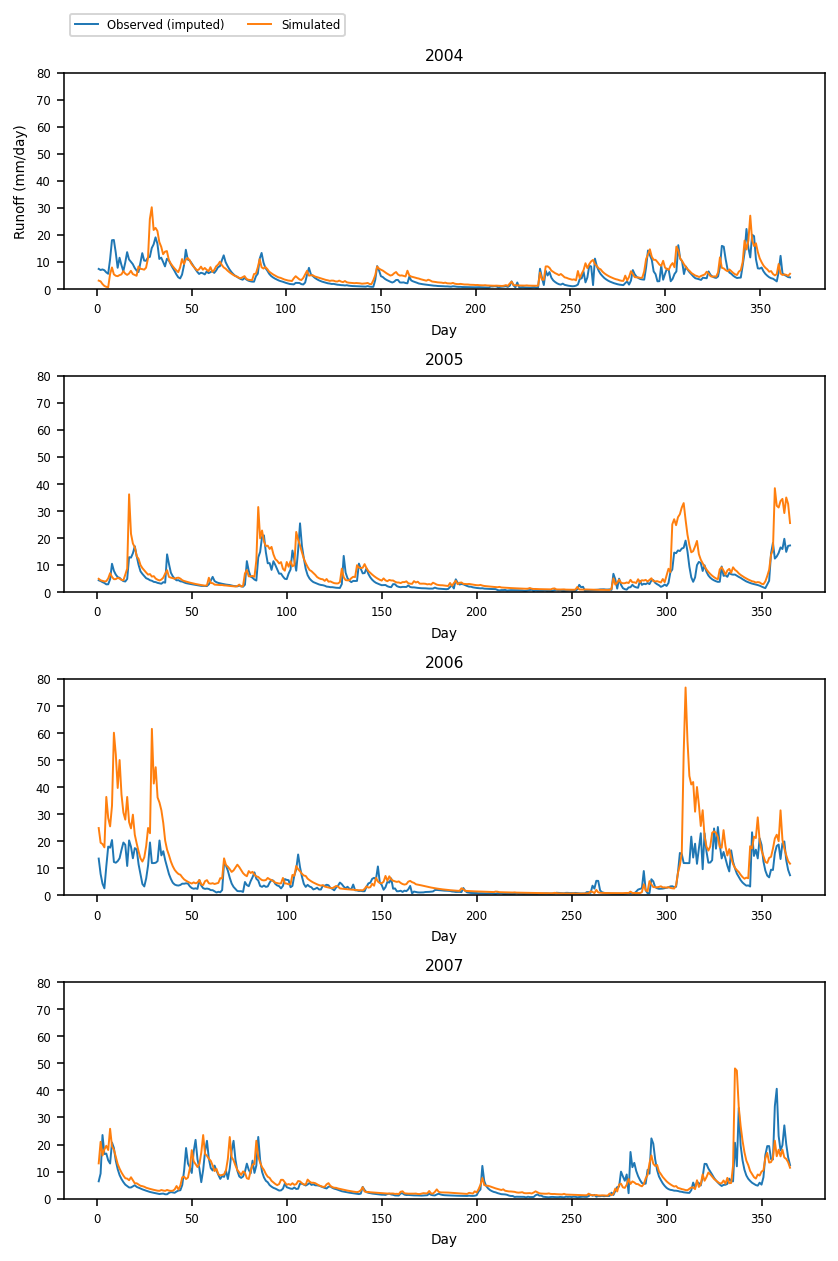

In [35]:
# Predicting measurements removed for low quality

velma_start = pd.to_datetime('01-01-2004')
velma_end = pd.to_datetime('12-31-2007')

# Remove dates with poor quality tags/rating table exceedances
low_qual = quality[(quality['Quality'].isin([8, 10, 160, 161, 179, 254]))]
gap_data = low_qual.merge(df, left_index=True, right_index=True, how='left')
gap_data_04_07 = gap_data[(gap_data.index >= velma_start) & (gap_data.index <= velma_end)].copy()
X_gap = gap_data_04_07.drop(columns=['Quality'], axis=1)

X_gap = (X_gap - train_mean[:-1]) / train_std[:-1]
gap_pred = svr.predict(X_gap)
gap_pred = (gap_pred * train_std['flow_mm_day']) + train_mean['flow_mm_day']

gap_data_04_07['flow_mm_day'] = gap_pred

# Combine imputed flow with observed data
gap_data_04_07_imp = gap_data_04_07.drop(columns=['Quality', 'mean_ppt_mm', 'mean_temp_c', 'Mean', 'Mean', 'year_cos',
                                                  'year_sin', 'precip_sum-2t', 'precip_t-1', 'precip_t-2',
                                                  'precip_t-3'], axis=1).copy()
gap_data_04_07_imp['doy'], gap_data_04_07_imp['year'] = gap_data_04_07_imp.index.dayofyear, gap_data_04_07_imp.index.year

runoff_obs_drop = runoff_obs.drop(gap_data_04_07_imp.index)
runoff_obs_drop = runoff_obs_drop.rename(columns={'runoff_obs': 'flow_mm_day'})
runoff_obs_imp = pd.concat([runoff_obs_drop, gap_data_04_07_imp]).sort_index()

# Plot imputed data vs. VELMA simulated data
runoff_obs_imp_yearly = pd.pivot_table(runoff_obs_imp, index=['doy'], columns=['year'], values=['flow_mm_day'])

# Plot average daily runoff vs. VELMA simulated runoff
years = runoff_obs_imp_yearly.columns.get_level_values(1)
fig, axes = plt.subplots(ncols=1, nrows=len(years), figsize=(6, 9))
for col, year in enumerate(years):
    runoff_obs_imp_yearly.iloc[:, col].plot(ax=axes[col], label='Observed (imputed)', linewidth=1)
    runoff_sim_yearly.iloc[:, col].plot(ax=axes[col], label='Simulated', linewidth=1)
    axes[col].set_title(year)
    axes[col].set_ylim([0, 80])
axes[0].legend(loc='upper left', bbox_to_anchor=(0, 1.3), fancybox=True, ncol=2)
axes[0].set_ylabel('Runoff (mm/day)')
plt.tight_layout()

In [37]:
# Computing Nash-Sutcliffe
def NS(s, o):
    """
        Nash Sutcliffe efficiency coefficient
        input:
        s: simulated
        o: observed
        output:
        ns: Nash Sutcliffe efficient coefficient
        """
    # s,o = filter_nan(s,o)
    return 1 - np.sum((s-o)**2)/np.sum((o-np.mean(o))**2)

NS(baseline04_19['Runoff_All(mm/day)_Delineated_Average'], runoff_obs_imp['flow_mm_day'])

-0.18041384212230582

In [38]:
NS(baseline04_19['Runoff_All(mm/day)_Delineated_Average'], runoff_obs['runoff_obs'])

0.5665312861952982